In [2]:
from typing import Callable, List

import tensorflow as tf
import tensorflow_datasets as tfds
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import Tensor

# Data aquisition&preparation

In [ ]:
# # Oxford-IIIT pet dataset: https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet
# dataset_name = "oxford_iiit_pet"  # dataset name
# split = [
#     "train[:80%]+test[:80%]",
#     "train[80%:]+test[80%:]",
# ]  # train-validation split

In [9]:
# Oxford Flowers 102 dataset: https://www.tensorflow.org/datasets/catalog/oxford_flowers102
dataset_name = "oxford_flowers102"  # dataset name
split = [
    'train', #"train[:80%]+validation[:80%]+test[:80%]",
    'validation', #"train[80%:]+validation[80%:]+test[80%:]",
]  # train-validation split

In [5]:
# Hyperparameters
IMAGE_SIZE = 64  # resized image size
BATCH_SIZE = 32  # batch size
TIMESTEPS = 500  # number of timesteps (noise levels)

LEARNING_RATE = 2e-4    # learning rate
EPOCHS = 100            # number of epochs

MIN_BETA = 1e-4  # minimum beta
MAX_BETA = 0.02  # maximum beta

ACTIVATION = tf.keras.activations.swish  # activation function
UNET_FILTERS = [64, 128, 256, 512]       # U-Net filter sizes
NUM_RES_BLOCKS = 2                       # number of residual blocks in each U-Net level
NUM_GROUPS = 8                           # number of groups for group normalization
EMA_RATE = 0.999                         # exponential moving average rate

KID_IMAGE_SIZE = 75
KID_DIFF_STEPS = 5

In [10]:
# preprocess an image
def preprocess_image(data):
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)  # find the smallest dimension
    img = tf.image.crop_to_bounding_box(  # crop the image to a square
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )
    img = tf.cast(img, dtype=tf.float32)  # cast the image to float32
    img = tf.image.resize(img, size=(IMAGE_SIZE, IMAGE_SIZE), antialias=True)  # resize the image to img_size x img_size
    return tf.clip_by_value(img * 2.0 / 255.0 - 1.0, -1.0, 1.0)  # normalize the image to [-1, 1]


def reverse_transform(img, cast_int=True):
    transformed = tf.clip_by_value((img + 1.0) / 2.0 * 255.0, 0.0, 255.0)  # reverse the normalization
    return transformed.numpy().astype(np.uint8) if cast_int else transformed

def augment_image(img):
    return tf.image.random_flip_left_right(img) # flip the image horizontally with 50% probability

In [11]:
# preprocess a dataset
def preprocess_dataset(dataset, augment=False):
    ds = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # preprocess images
    if augment:
        ds = ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE) # augment the dataset if needed
    return (
        ds.batch(BATCH_SIZE, drop_remainder=True)  # organize the dataset into batches
        .shuffle(2 * BATCH_SIZE)  # shuffle the dataset
        .prefetch(buffer_size=tf.data.AUTOTUNE)  # prefetch data for better performance
    )


# load dataset from tensorflow datasets with the given name
def load_data(dataset_name):
    train_ds, val_ds = tfds.load(dataset_name, split=split, shuffle_files=True)  # load the dataset
    train_ds = preprocess_dataset(train_ds, True) # preprocess the training dataset with augmentation
    val_ds = preprocess_dataset(val_ds)  # preprocess the validation dataset
    return train_ds, val_ds

In [12]:
train_ds, val_ds = load_data(dataset_name) # load, split and preprocess the dataset

In [13]:
def show(img): # display an image
    plt.figure(figsize=(3, 3))
    plt.imshow(reverse_transform(img)) # reverse the normalization and display the image
    plt.axis("off")
    plt.show()


def plot(imgs): # display a list of images in a row
    _, axs = plt.subplots(figsize=(len(imgs) * 2, 2), ncols=len(imgs), nrows=1) # create subplots
    for idx, img in enumerate(imgs):
        axs[idx].imshow(reverse_transform(img))
        axs[idx].axis("off")
    plt.tight_layout()

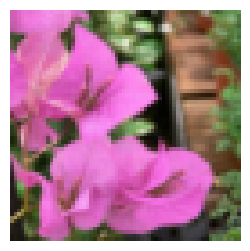

In [14]:
demo_img = next(iter(train_ds.unbatch().take(1)))
show(demo_img)

## Diffusion utility

In [15]:
class Diffusion: # diffusion utilities
    def __init__(self, timesteps, min_beta, max_beta):
        self.timesteps = timesteps  # number of timesteps (noise levels)
        self.min_beta = min_beta  # first beta
        self.max_beta = max_beta  # last beta

        self.betas = tf.linspace(min_beta, max_beta, timesteps)  # setting schedule for beta (linear schedule)
        self.alphas = 1 - self.betas  # alpha_t = 1 - beta_t
        self.alphas_cum_prod = tf.math.cumprod(self.alphas)  # cumulative product of alphas
        self.alphas_cum_prod_prev = tf.concat([[1.0], self.alphas_cum_prod[:-1]], axis=0)  # cumulative product of alphas shifted
        self.recip_sqrt_alphas = tf.math.sqrt(1.0 / self.alphas)  # reciprocals of square roots of alphas
        self.sqrt_alphas_prod = tf.math.sqrt(self.alphas_cum_prod)  # square roots of cumulative product of alphas
        self.sqrt_one_minus_alphas_prod = tf.math.sqrt(1.0 - self.alphas_cum_prod)  # square roots of 1 - cumulative product of alphas

        self.posterior_variance = self.betas * (1.0 - self.alphas_cum_prod_prev) / (1.0 - self.alphas_cum_prod) # posterior variance (Equation 6, 7)

    def extract(self, series, t, x_shape): # extract the corresponding values from a data series for given timesteps
        out = tf.gather(series, t)
        return tf.reshape(out, [x_shape[0], 1, 1, 1])

    def q_sample(self, x_start, t, noise=None): # forward diffusion starting from x_start and applying t timesteps of noise
        x_start_shape = tf.shape(x_start)
        if noise is None:
            noise = tf.random.normal(x_start_shape, dtype=x_start.dtype) # use Gaussian noise if not provided

        sqrt_alphas_prod_t = self.extract(self.sqrt_alphas_prod, t, x_start_shape)
        sqrt_one_minus_alphas_prod_t = self.extract(self.sqrt_one_minus_alphas_prod, t, x_start_shape)
        return sqrt_alphas_prod_t * x_start + sqrt_one_minus_alphas_prod_t * noise  # Equation 12

    def p_sample_step(self, model, x, t, t_index): # denoise one step
        x_shape = tf.shape(x)
        beta_t = self.extract(self.betas, t, x_shape)
        sqrt_one_minus_alphas_prod_t = self.extract(self.sqrt_one_minus_alphas_prod, t, x_shape)
        recip_sqrt_alphas_t = self.extract(self.recip_sqrt_alphas, t, x_shape)
        noise_pred = model([x, t], training=False) # predict noise at current timestep
        model_mean = recip_sqrt_alphas_t * (x - noise_pred * beta_t / sqrt_one_minus_alphas_prod_t)  # Equation 11

        if t_index == 0:
            return model_mean
        else:
            posterior_variance_t = self.extract(self.posterior_variance, t, x_shape)
            noise = tf.random.normal(x_shape, dtype=x.dtype)  # sample noise from N(0, I)
            return model_mean + tf.math.sqrt(posterior_variance_t) * noise  # Algorithm 2, Line 4

    def p_sample_full(self, model, shape, img=None, timesteps=None): # complete denoising process
        if timesteps is None:
            timesteps = self.timesteps # use the maximum timesteps if not provided
        if img is None:
            img = tf.random.normal(shape, dtype=tf.float32)  # pure noise initially
        imgs = [img] # collect denoised images at each timestep
        for t in reversed(range(timesteps)):
            t = t * self.timesteps // timesteps
            t_batch = tf.cast(tf.fill((shape[0],), t), dtype=tf.int64)
            img = self.p_sample_step(model, img, t_batch, t) # denoise one step
            imgs.append(img)
        return imgs

    def generate_images(self, model, num_images=16, image_size=IMAGE_SIZE, timesteps=None): # generate multiple images
        return self.p_sample_full(model, (num_images, image_size, image_size, 3), timesteps=timesteps)

In [16]:
diffusion = Diffusion(
    timesteps=TIMESTEPS,
    min_beta=MIN_BETA,
    max_beta=MAX_BETA,
) # create a diffusion utility

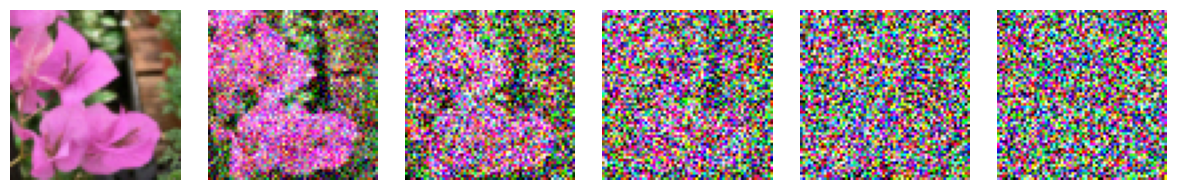

In [17]:
# demonstrate the noising process
noisy_images = [
    tf.squeeze(diffusion.q_sample(tf.expand_dims(demo_img, 0), tf.constant([t])))
    for t in [0, 100, 200, 300, 400, 499]
]
plot(noisy_images)

## Neural network

U-net

In [18]:
# sinusoidal time embedding
def time_embedding(dim: int):
    def apply(inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        half_dim = dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = inputs[:,None] * emb[None,:]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb

    return apply


# residual block with 2 convolutional layers and group normalization 
def residual_block(filters: int, groups: int, activation_fn) -> Callable[[List[Tensor]], Tensor]:
    def apply(inputs: List[Tensor]) -> Tensor:
        x, t = inputs
        # store residual connection
        if filters == x.shape[3]:
            residual = x
        else:
            residual = tf.keras.layers.Conv2D(filters, (1, 1))(x)

        # activate and arrange time data
        t = activation_fn(t)
        t = tf.keras.layers.Dense(filters)(t)[:,None,None,:]

        # first group normalization
        if x.shape[3] >= groups:
            x = tf.keras.layers.GroupNormalization(groups=groups)(x)
            x = activation_fn(x)

        # first convolution
        x = tf.keras.layers.Conv2D(filters, (3, 3), activation=tf.keras.activations.swish, padding="same", )(x)

        # add time data to other features, apply group normalization and activation
        x = tf.keras.layers.Add()([x, t])
        x = tf.keras.layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)

        # second convolution
        x = tf.keras.layers.Conv2D(filters, (3, 3), activation=tf.keras.activations.swish, padding="same", )(x)

        # add residual connection
        x = tf.keras.layers.Add()([x, residual])
        return x

    return apply


# create a U-Net with the given filter sizes
def create_u_net(filters: List[int], num_res_blocks: int, num_groups: int, activation_fn) -> tf.keras.Model:
    # input layers: image, time
    image_input = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    time_input = tf.keras.layers.Input(shape=(), dtype=tf.int64)

    x = image_input
    t = time_embedding(filters[0]*4)(time_input) # embed time data
    skip_connections = [] # list to store skip connections

    # down sampling
    for f in filters:
        # add multiple residual blocks
        for _ in range(num_res_blocks):
            x = residual_block(f, num_groups, activation_fn)([x, t])
            if f != filters[-1]:
                # storing layer outputs for skip connections
                skip_connections.append(x)

        if f != filters[-1]:
            # max pooling
            x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # up sampling
    for f in reversed(filters[:-1]):
        # up sampling + convolution
        x = tf.keras.layers.UpSampling2D((2, 2))(x)
        x = tf.keras.layers.Conv2D(f, (3, 3), padding="same")(x)
        # multiple residual blocks
        for _ in range(num_res_blocks):
            # concatenate skip connection
            x = tf.keras.layers.Concatenate()([x, skip_connections.pop()])
            # residual block
            x = residual_block(f, num_groups, activation_fn)([x, t])

    # output layer with no activation
    output_layer = tf.keras.layers.Conv2D(3, (1, 1), kernel_initializer="zeros")(x)
    # create model with input and output layers
    u_net = tf.keras.Model([image_input, time_input], output_layer)
    return u_net


network = create_u_net(UNET_FILTERS, NUM_RES_BLOCKS, NUM_GROUPS, ACTIVATION) # train network
ema_network = create_u_net(UNET_FILTERS, NUM_RES_BLOCKS, NUM_GROUPS, ACTIVATION) # exponential moving average network
ema_network.set_weights(network.get_weights()) # initialize EMA network with the same weights

## Kernel Inception Distance

In [ ]:
class KID(tf.keras.metrics.Metric):
    def __init__(self, kid_image_size, **kwargs):
        super().__init__(name="kid", **kwargs)
        self.tracker = tf.keras.metrics.Mean()

        self.encoder = tf.keras.Sequential([
            tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
            tf.keras.layers.Lambda(lambda img: reverse_transform(img, cast_int=False)),
            tf.keras.layers.Resizing(height=kid_image_size, width=kid_image_size),
            tf.keras.layers.Lambda(tf.keras.applications.inception_v3.preprocess_input),
            tf.keras.applications.InceptionV3(
                include_top=False,
                input_shape=(kid_image_size, kid_image_size, 3),
                weights="imagenet",
            ),
            tf.keras.layers.GlobalAveragePooling2D(),
        ])

    def get_kernel(self, features_1, features_2):
        feature_dims = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dims + 1.0) ** 3.0

    def update_state(self, original, generated):
        original_features = self.encoder(original, training=False)
        generated_features = self.encoder(generated, training=False)

        original_kernel = self.get_kernel(original_features, original_features)
        generated_kernel = self.get_kernel(generated_features, generated_features)
        cross_kernel = self.get_kernel(original_features, generated_features)

        batch_size = tf.shape(original_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean = lambda kernel: tf.reduce_sum(kernel * (1.0 - tf.eye(batch_size))) / (batch_size_f * (batch_size_f - 1.0))
        kid = mean(original_kernel) + mean(generated_kernel) - 2.0 * tf.reduce_mean(cross_kernel)

        self.tracker.update_state(kid)

    def result(self):
        return self.tracker.result()

    def reset(self):
        self.tracker.reset_state()

## Diffusion Model

In [19]:
class DiffusionModel(tf.keras.Model): # diffusion model that performs training based on the diffusion process
    def __init__(self, diffusion, net, ema_net, ema_rate):
        super().__init__()
        self.diffusion = diffusion # diffusion utility
        self.network = net # U-net
        self.ema_network = ema_net # EMA U-net
        self.ema_rate = ema_rate # EMA rate
        # self.kid = KID(KID_IMAGE_SIZE)

    def call(self, Xs, training=None, mask=None): # functional interface
        if training:
            return self.network(Xs) # use the base network during training
        return self.ema_network(Xs) # use the EMA network otherwise

    def random_t(self, Xs): # sample a batch of random timestep uniformally from [0, T] 
        result = tf.random.uniform(
            (tf.shape(Xs)[0],),
            minval=0,
            maxval=self.diffusion.timesteps,
            dtype=tf.int64, # use int64 for more precision
        )
        return result

    def step(self, Xs, t, training=True):
        noise = tf.random.normal(tf.shape(Xs), dtype=Xs.dtype) # sample a batch of noise from N(0, I)
        Xs_noisy = self.diffusion.q_sample(Xs, t, noise) # apply t timesteps of noise to Xs
        if training:
            noise_pred = self.network([Xs_noisy, t], training=training) # predict noise at current timestep with the base network
        else:
            noise_pred = self.ema_network([Xs_noisy, t], training=training) # predict noise at current timestep with the EMA network
        return self.loss(noise, noise_pred) # calculate loss between predicted noise and sampled noise

    def train_step(self, Xs):
        t = self.random_t(Xs) # sample random timesteps
        with tf.GradientTape() as tape:
            loss = self.step(Xs, t, training=True) # calculate loss for a denoise step
        grads = tape.gradient(loss, self.network.trainable_weights) # get gradients
        self.optimizer.apply_gradients(zip(grads, self.network.trainable_weights)) # backpropagate
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.ema_rate * ema_weight + (1 - self.ema_rate) * weight) # update EMA weights with exponential moving average
        return {"loss": loss}

    def test_step(self, Xs):
        batch_size = Xs.shape[0]
        t = self.random_t(Xs) # sample random timesteps
        loss = self.step(Xs, t, training=False) # calculate loss for a denoise step

        #generated = tf.convert_to_tensor([self.diffusion.generate_image(self, timesteps=KID_DIFF_STEPS)[-1][0] for _ in range(batch_size)])
        #self.kid.update_state(Xs, generated)
        #kid = self.kid.result()
        #self.kid.reset()

        return {"loss": loss}#, "kid": kid}

In [20]:
model = DiffusionModel(diffusion, network, ema_network, EMA_RATE) # create a diffusion model

In [21]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE),
)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="u_net.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback],
    verbose=2,
)

Epoch 1/100
31/31 - 23s - loss: 0.0232 - val_loss: 0.0301 - 23s/epoch - 753ms/step
Epoch 2/100
31/31 - 21s - loss: 0.0616 - val_loss: 0.0385 - 21s/epoch - 690ms/step
Epoch 3/100
31/31 - 23s - loss: 0.0347 - val_loss: 0.0497 - 23s/epoch - 733ms/step
Epoch 4/100
31/31 - 22s - loss: 0.0404 - val_loss: 0.0360 - 22s/epoch - 700ms/step
Epoch 5/100
31/31 - 21s - loss: 0.0223 - val_loss: 0.0504 - 21s/epoch - 688ms/step
Epoch 6/100
31/31 - 24s - loss: 0.0237 - val_loss: 0.0329 - 24s/epoch - 784ms/step
Epoch 7/100
31/31 - 21s - loss: 0.0392 - val_loss: 0.0539 - 21s/epoch - 690ms/step
Epoch 8/100
31/31 - 25s - loss: 0.0222 - val_loss: 0.0704 - 25s/epoch - 791ms/step
Epoch 9/100
31/31 - 21s - loss: 0.0423 - val_loss: 0.0453 - 21s/epoch - 694ms/step
Epoch 10/100
31/31 - 21s - loss: 0.0449 - val_loss: 0.0359 - 21s/epoch - 692ms/step
Epoch 11/100
31/31 - 22s - loss: 0.0480 - val_loss: 0.0397 - 22s/epoch - 695ms/step
Epoch 12/100
31/31 - 25s - loss: 0.0474 - val_loss: 0.0437 - 25s/epoch - 791ms/step
E

# Evaluation

## Loss

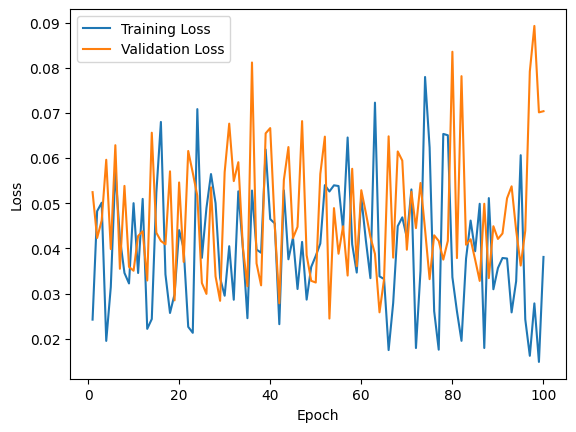

In [44]:
# plot training and validation loss
ticks = range(1, len(history.history["loss"]) + 1)
plt.plot(ticks, history.history["loss"], label="Training Loss")
plt.plot(ticks, history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Kernel Inception Distance

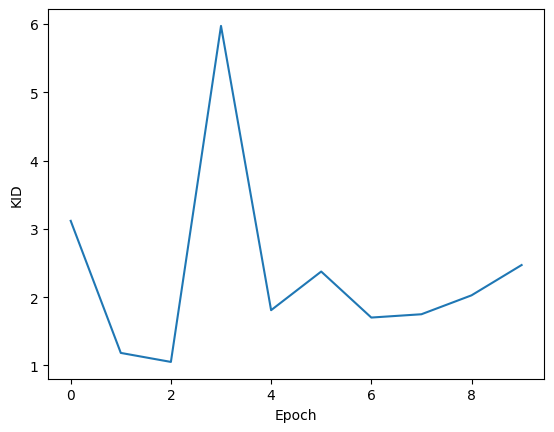

In [ ]:
ticks = range(1, len(history.history["val_kid"]) + 1)
plt.plot(ticks, history.history["val_kid"])
plt.xlabel("Epoch")
plt.ylabel("KID")
plt.show()

## Generate random images

In [ ]:
# model.load_weights("u_net.h5")

In [ ]:
def reconstruct_images(image_count=5, t=50): # apply noise to images and denoise them to test reconstruction capability
    original_images = next(iter(val_ds.unbatch().batch(image_count))) # get images from the validation dataset
    noisy_images = [
        diffusion.q_sample(tf.expand_dims(img, 0), tf.constant([t])) # apply t timesteps of noise to each image
        for img in original_images
    ]
    reconstructed_images = [
        diffusion.p_sample_full(model, (1, IMAGE_SIZE, IMAGE_SIZE, 3), img, t)[-1] # denoise each image
        for img in noisy_images
    ]

    plt.figure(figsize=(2 * image_count, 2 * 3))
    for i in range(image_count):
        # Noisy versions in the first row
        plt.subplot(3, image_count, i + 0 * image_count + 1)
        plt.imshow(tf.squeeze(reverse_transform(noisy_images[i])))
        plt.title("Noisy")
        plt.axis("off")

        # Reconstructed versions in the second row
        plt.subplot(3, image_count, i + 1 * image_count + 1)
        plt.imshow(tf.squeeze(reverse_transform(reconstructed_images[i])))
        plt.title("Reconstructed")
        plt.axis("off")

        # Original versions in the third row
        plt.subplot(3, image_count, i + 2 * image_count + 1)
        plt.imshow(reverse_transform(original_images[i]))
        plt.title("Original")
        plt.axis("off")

    plt.show()

In [ ]:
reconstruct_images(3, 300) # reconstruct 3 images with 300 applied noise levels

In [ ]:
def generate_image(model): # illustrate the denoising process during image generation
    imgs = diffusion.generate_images(model, 1)[0] # generate an image
    imgs = list(imgs[:: (len(imgs) // 5)]) # select images at different timesteps
    plot([tf.squeeze(img) for img in imgs])

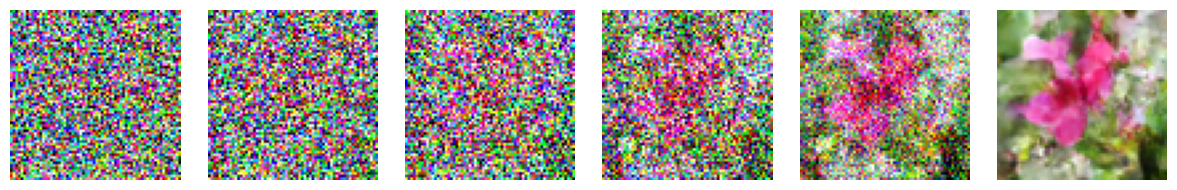

In [ ]:
generate_image(model)

In [39]:
def generate_images(num_rows=4, num_cols=8, figsize=(12, 5)): # generate multiple images
    generated_samples = diffusion.generate_images(model, num_rows * num_cols)[-1]
    generated_samples = reverse_transform(generated_samples) # reverse the normalization of generated images
    _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i, image in enumerate(generated_samples):
        if num_rows == 1:
            ax[i].imshow(image)
            ax[i].axis("off")
        else:
            ax[i // num_cols, i % num_cols].imshow(image)
            ax[i // num_cols, i % num_cols].axis("off")
    plt.tight_layout()
    plt.show()

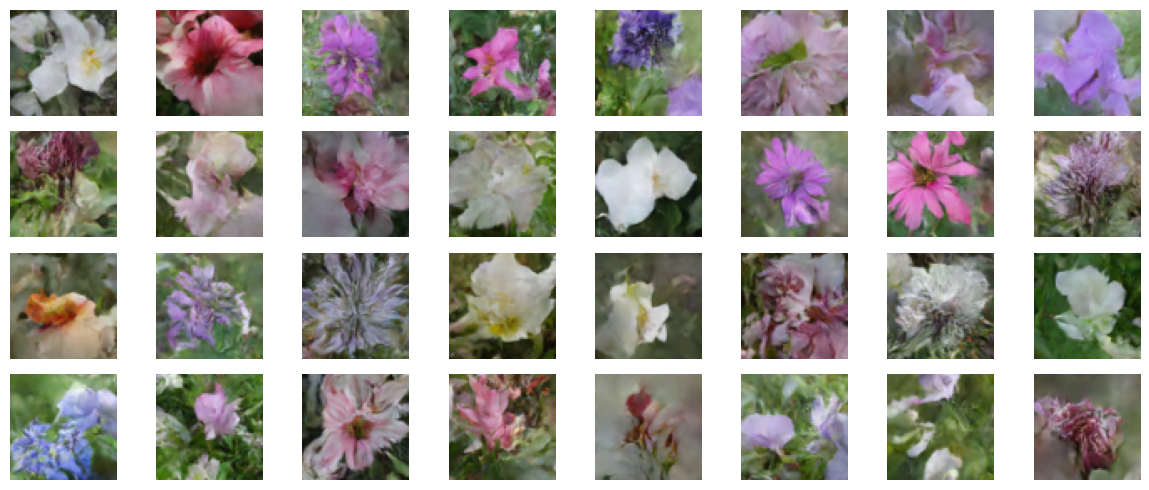

In [40]:
generate_images(4, 8) # generate 32 images